In [ ]:
import pickle
import os
import re

subfolder = "inception70/Opt_noChange_5x_fastLink"   
filename = "No_mem_Fullopt_5x_NoC1.0_Comp0.1.pkl"

# subfolder = "inceptionALL"
# filename = "zero_mem_ALL.pkl"


results_dir = f"/home/sfischer/Documents/projects/wk_LinProg/optimization_results/{subfolder}"
model_path = os.path.join(results_dir, filename)

memory_mapping = {}

with open(model_path, "rb") as f:
    model = pickle.load(f)

for v in model.variables():
    # print(f"{v.name} = {v.varValue}")
    if v.name.startswith("PE") and v.name.endswith("_total_memory"):

        match = re.search(r'PE(\d+)_total_memory', v.name)
        number = int(match.group(1))
        memory_mapping[number] = int(v.varValue)

print("Memory mapping:", memory_mapping)
print("\nAll constraints in the model:")
for cname, constraint in model.constraints.items():
    print(f"{cname}: {constraint}")
max_router_delay_value = None
mapping = {}
reverse_mapping = {}
combined= {}
for v in model.variables():
    if v.name.startswith("t_") and "_map_" in v.name and v.varValue == 1.0:
        # Example: t_0_map_12
        print(f"Debug: Found mapping variable {v.name} with value {v.varValue}")
        parts = v.name.split("_")
        print(f"Debug: Split parts: {parts}")
        task = int(parts[1])
        mapped_to = int(parts[3])
        print(f"Debug: Mapping task {task} to PE {mapped_to}")
        mapping[task] = mapped_to
        # Build reverse mapping
        if mapped_to not in reverse_mapping:
            reverse_mapping[mapped_to] = []
        reverse_mapping[mapped_to].append(task)
        print(f"Debug: reverse_mapping[{mapped_to}] now {reverse_mapping[mapped_to]}")
        
    if v.name == "max_router_delay":
        max_router_delay_value = v.varValue
        print(f"Debug: Found max_router_delay variable with value {max_router_delay_value}")

# print("Task mapping:", mapping)
print("Reverse mapping:", reverse_mapping)
# print(reverse_mapping)  # Print keys of the first mapped task
for i in reverse_mapping:
    print(i,reverse_mapping[i])  # Print all mappings
    combined[reverse_mapping[i][0]] = (reverse_mapping[i],memory_mapping[i])

print("Combined mapping:", combined)

total_sending={}
total_comp={}
total_memory={}
delay_max={}
delay_min={}
delay_duration={}
for pe in reverse_mapping:
    # print(f"pe {pe}")
    # print(pe,reverse_mapping[pe])  # Print all mappings

    total_sending[pe] = 0
    total_comp[pe] = 0
    total_memory[pe] = 0
    delay_max[pe] = 0
    delay_min[pe] = float('inf')
    for task in reverse_mapping[pe]:
        for v in model.variables():
            if v.name=="t_send_"+str(task):
                total_sending[pe] += v.varValue
            if v.name=="t_comp_"+str(task):  
                total_comp[pe] += int(v.varValue)
                print(f"Debug: found t_comp pe={pe}, task={task}, v.name={v.name}, v.varValue={v.varValue} new total comp={total_comp[pe]}")
            if v.name=="PE"+str(pe)+"_total_memory":
                total_memory[pe] = v.varValue

            if v.name=="t"+str(task)+"_start":
                print(f"Debug: Checking start time for pe={pe}, task={task}, v.name={v.name}, v.varValue={v.varValue}, current delay_min={delay_min[pe]}")
                if v.varValue < delay_min[pe]:
                    delay_min[pe] = v.varValue
                    print(f"Debug: Updated delay_min[{pe}] to {delay_min[pe]}")
            if v.name=="t"+str(task)+"_end_":
                print(f"Debug: Checking end time for pe={pe}, task={task}, v.name={v.name}, v.varValue={v.varValue}, current delay_max={delay_max[pe]}")
                if v.varValue > delay_max[pe]:
                    delay_max[pe] = v.varValue
                    print(f"Debug: Updated delay_max[{pe}] to {delay_max[pe]}")

        delay_duration[pe] = delay_max[pe] - delay_min[pe]


print("Reverse mapping:", reverse_mapping)
print(f"total_comp: {total_comp}")
print(f"total_sending:", total_sending)
print(f"total_memory:", total_memory)

print(f"delay_max:", delay_max)
print(f"delay_min:", delay_min)
print(f"delay_duration:", delay_duration)


# print("\nAll constraints in the model:")
# for cname, constraint in model.constraints.items():
#     print(f"{cname}: {constraint}")

for v in model.variables():
#     if "order_choose" in v.name:
#         print(f"{v.name} = {v.varValue}")

#     if "same_" in v.name:
#         print(f"{v.name} = {v.varValue}")
#     if "t_send" in v.name:
#         print(f"{v.name} = {v.varValue}")

#     if "_map_" in v.name:
#         print(f"{v.name} = {v.varValue}")

    if "_start" in v.name:
        print(f"{v.name} = {v.varValue}")

    if "_end_" in v.name:
        print(f"{v.name} = {v.varValue}")

# for v in model.variables():

#     if "comp" in v.name:
#         print(f"{v.name} = {v.varValue}")

Memory mapping: {0: 1191, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 1: 274, 2: 1924, 3: 2554, 4: 7716, 5: 265, 6: 12630, 7: 3028, 8: 0, 9: 0}

All constraints in the model:
_C1: -t0_end_ + t_comp_0 <= 0
_C2: t0_start >= 0
_C3: same_0_1_and_0 - t_0_map_0 <= 0
_C4: same_0_1_and_0 - t_1_map_0 <= 0
_C5: same_0_1_and_0 - t_0_map_0 - t_1_map_0 >= -1
_C6: same_0_1_and_1 - t_0_map_1 <= 0
_C7: same_0_1_and_1 - t_1_map_1 <= 0
_C8: same_0_1_and_1 - t_0_map_1 - t_1_map_1 >= -1
_C9: same_0_1_and_2 - t_0_map_2 <= 0
_C10: same_0_1_and_2 - t_1_map_2 <= 0
_C11: same_0_1_and_2 - t_0_map_2 - t_1_map_2 >= -1
_C12: same_0_1_and_3 - t_0_map_3 <= 0
_C13: same_0_1_and_3 - t_1_map_3 <= 0
_C14: same_0_1_and_3 - t_0_map_3 - t_1_map_3 >= -1
_C15: same_0_1_and_4 - t_0_map_4 <= 0
_C16: same_0_1_and_4 - t_1_map_4 <= 0
_C17: same_0_1_and_4 - t_0_map_4 - t_1_map_4 >= -1
_C18: same_0_1_and_5 - t_0_map_5 <= 0
_C19: same_0_1_and_5 - t_1_map_5 <= 0
_C20: same_0_1_and_5 - t_0_map_5 - t_1_map_5 >= -1
_C21: same_0_1_and_6 - 

In [28]:
# # ...existing code...
# print(f"total_comp: {total_comp}")
# print(f"total_sending:", total_sending)
# print(f"total_memory:", total_memory)

import numpy as np


comp_values = list(total_comp.values())
print(f"Sum of total_comp: {sum(comp_values):.2f}")
print(f"Variance of total_comp: {np.var(comp_values):.2f}")
print(f"Standard deviation of total_comp: {np.std(comp_values):.2f}")

sending_values = list(total_sending.values())
print(f"Sum of total_sending: {sum(sending_values):.2f}")
print(f"Variance of total_sending: {np.var(sending_values):.2f}")
print(f"Standard deviation of total_sending: {np.std(sending_values):.2f}")

memory_values = list(total_memory.values())
print(f"Sum of total_memory: {sum(memory_values):.2f}")
print(f"Variance of total_memory: {np.var(memory_values):.2f}")
print(f"Standard deviation of total_memory: {np.std(memory_values):.2f}")


print("max_router_delay:", max_router_delay_value)

Sum of total_comp: 128.00
Variance of total_comp: 80.50
Standard deviation of total_comp: 8.97
Sum of total_sending: 578.00
Variance of total_sending: 2731.94
Standard deviation of total_sending: 52.27
Sum of total_memory: 29582.00
Variance of total_memory: 16327996.69
Standard deviation of total_memory: 4040.79
max_router_delay: 150.0


Reverse mapping: {0: [0, 1, 2, 3], 1: [10, 8, 9], 2: [11, 12, 13, 14, 15, 16, 7], 3: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], 4: [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], 5: [4, 5, 6], 6: [53, 54, 55, 56, 57, 58, 59, 60, 61, 65, 66, 67, 68, 69], 7: [62, 63, 64]}
total_comp: {0: 13, 1: 7, 2: 19, 3: 22, 4: 28, 5: 6, 6: 28, 7: 5}
total_sending: {0: 137.0, 1: 137.0, 2: 48.0, 3: 48.0, 4: 45.0, 5: 137.0, 6: 0.0, 7: 26.0}
total_memory: {0: 1191.0, 1: 274.0, 2: 1924.0, 3: 2554.0, 4: 7716.0, 5: 265.0, 6: 12630.0, 7: 3028.0}
Computation (sum of t_comp): [13, 7, 19, 22, 28, 6, 28, 5]
Computation (duration): [150.0, 144.0, 67.0, 70.0, 73.0, 143.0, 95.0, 31.0]
Difference (duration - sum): [137.0, 137.0, 48.0, 48.0, 45.0, 137.0, 67.0, 26.0]


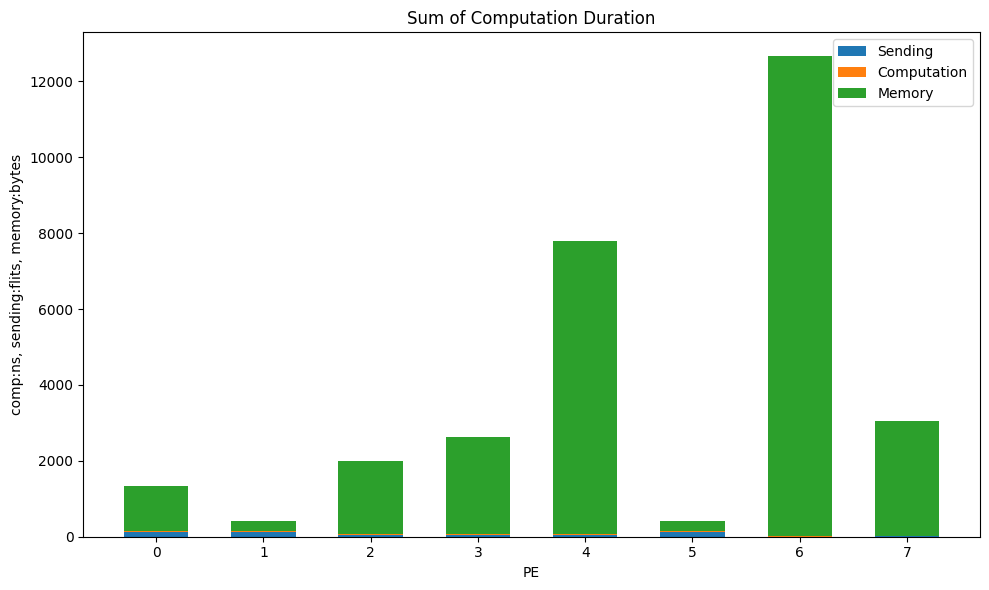

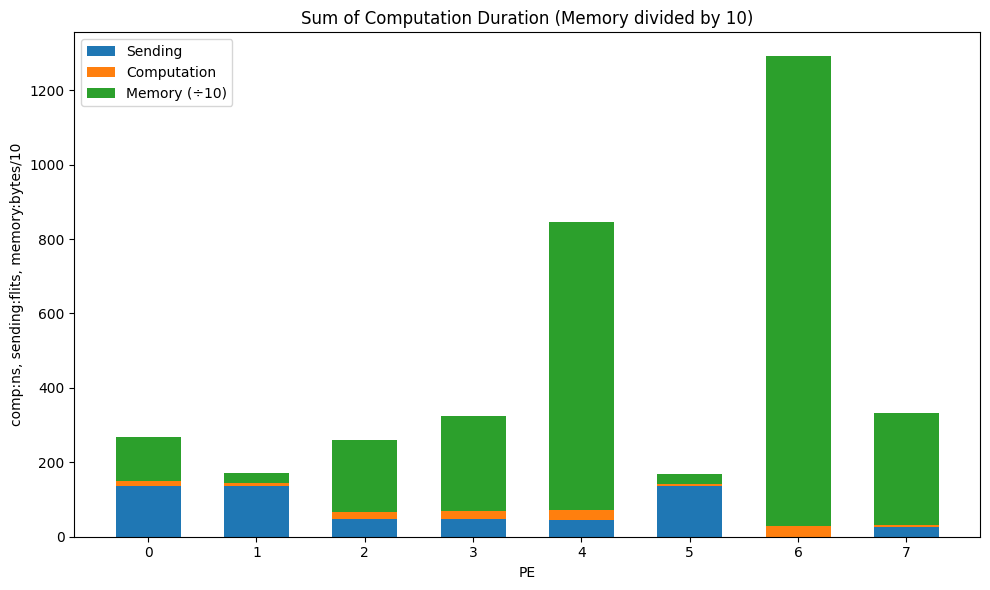

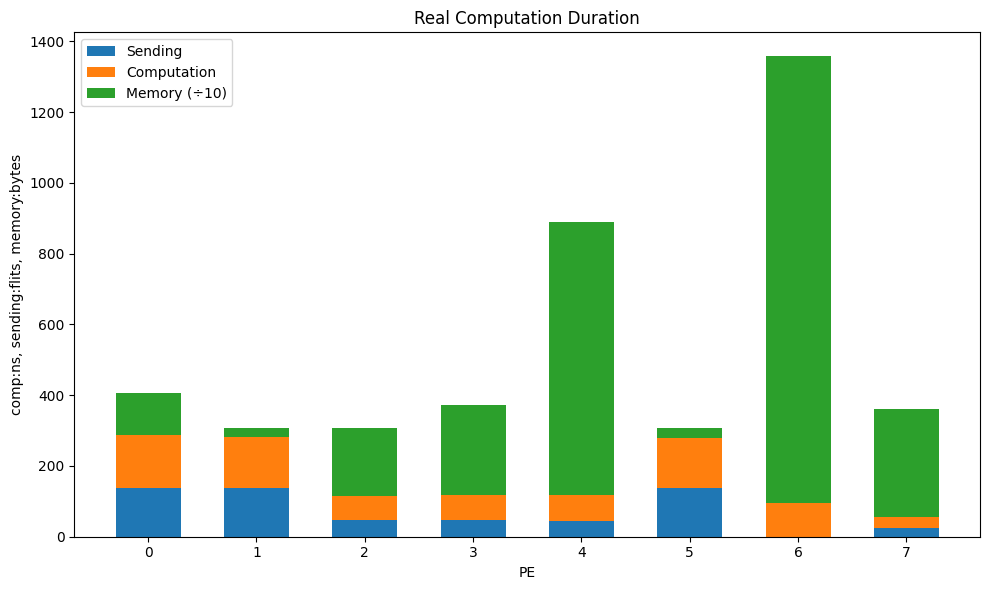

In [29]:
import matplotlib.pyplot as plt
import numpy as np
print("Reverse mapping:", reverse_mapping)
print(f"total_comp: {total_comp}")
print(f"total_sending:", total_sending)
print(f"total_memory:", total_memory)
# Ensure all PEs are included and sorted
pes = sorted(total_sending.keys())
sending = [total_sending.get(pe, 0) for pe in pes]
comp = [total_comp.get(pe, 0) for pe in pes]
memory = [total_memory.get(pe, 0) for pe in pes]
comp_real = [delay_duration.get(pe, 0) for pe in pes]
comp_diff = [c_real - c for c_real, c in zip(comp_real, comp)]
print("Computation (sum of t_comp):", comp)
print("Computation (duration):", comp_real)
print("Difference (duration - sum):", comp_diff)
# First graph: original values
bar_width = 0.6
ind = np.arange(len(pes))

plt.figure(figsize=(10, 6))
plt.bar(ind, sending, bar_width, label='Sending')
plt.bar(ind, comp, bar_width, bottom=sending, label='Computation')
bottoms = [s + c for s, c in zip(sending, comp)]
plt.bar(ind, memory, bar_width, bottom=bottoms, label='Memory')

plt.xlabel('PE')
plt.ylabel('comp:ns, sending:flits, memory:bytes')
plt.title('Sum of Computation Duration')
plt.xticks(ind, pes)
plt.legend()
plt.tight_layout()
plt.show()

# Second graph: memory values divided by 10
memory_div10 = [m / 10 for m in memory]
plt.figure(figsize=(10, 6))
plt.bar(ind, sending, bar_width, label='Sending')
plt.bar(ind, comp, bar_width, bottom=sending, label='Computation')
bottoms_div10 = [s + c for s, c in zip(sending, comp)]
plt.bar(ind, memory_div10, bar_width, bottom=bottoms_div10, label='Memory (÷10)')

plt.xlabel('PE')
plt.ylabel('comp:ns, sending:flits, memory:bytes/10')
plt.title('Sum of Computation Duration (Memory divided by 10)')
plt.xticks(ind, pes)
plt.legend()
plt.tight_layout()
plt.show()


# real computation time (Pe_end-pe_start not just Sum(t_comp))
memory_div10 = [m / 10 for m in memory]
plt.figure(figsize=(10, 6))
plt.bar(ind, sending, bar_width, label='Sending')
plt.bar(ind, comp_real, bar_width, bottom=sending, label='Computation')
bottoms_div10 = [s + c for s, c in zip(sending, comp_real)]
plt.bar(ind, memory_div10, bar_width, bottom=bottoms_div10, label='Memory (÷10)')

plt.xlabel('PE')
plt.ylabel('comp:ns, sending:flits, memory:bytes')
plt.title('Real Computation Duration')
plt.xticks(ind, pes)
plt.legend()
plt.tight_layout()
plt.show()

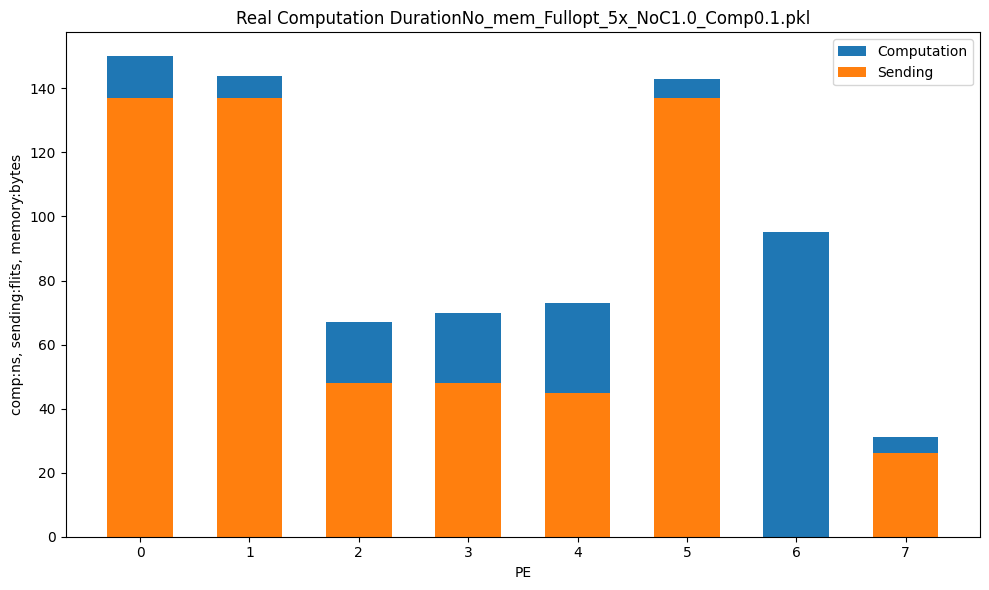

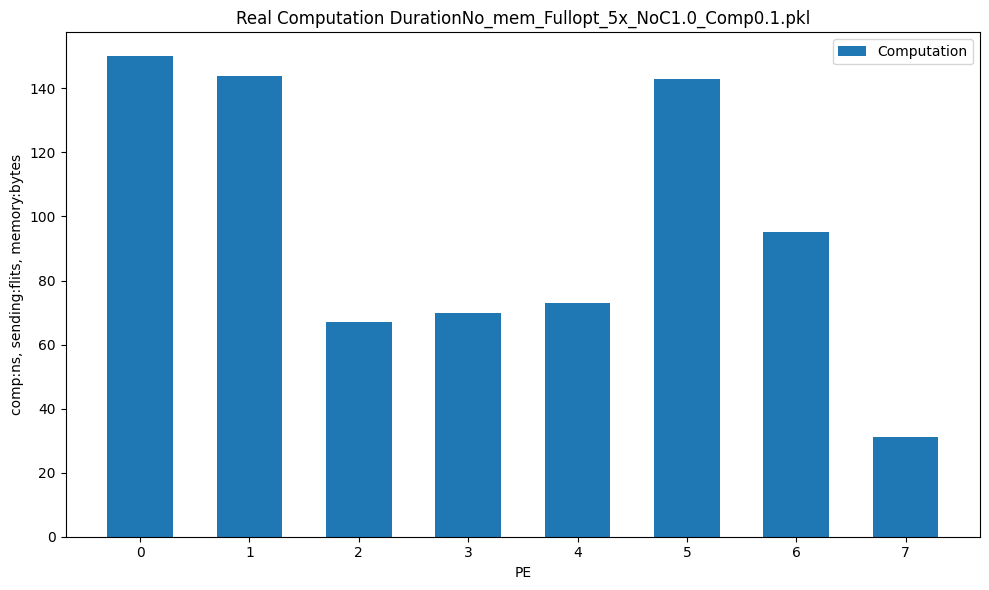

In [30]:
memory_div10 = [m / 10 for m in memory]
plt.figure(figsize=(10, 6))
plt.bar(ind, comp_real, bar_width, label='Computation')
plt.bar(ind, sending, bar_width, label='Sending')
bottoms_div10 = [s + c for s, c in zip(sending, comp_real)]
# plt.bar(ind, memory_div10, bar_width, bottom=bottoms_div10, label='Memory (÷10)')

plt.xlabel('PE')
plt.ylabel('comp:ns, sending:flits, memory:bytes')
plt.title('Real Computation Duration' + filename)
plt.xticks(ind, pes)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
# plt.bar(ind, sending, bar_width, label='Sending')
plt.bar(ind, comp_real, bar_width,  label='Computation')
bottoms_div10 = [s + c for s, c in zip(sending, comp_real)]
# plt.bar(ind, memory_div10, bar_width, bottom=bottoms_div10, label='Memory (÷10)')

plt.xlabel('PE')
plt.ylabel('comp:ns, sending:flits, memory:bytes')
plt.title('Real Computation Duration' + filename)
plt.xticks(ind, pes)
plt.legend()
plt.tight_layout()
plt.show()